# Calculating travel time to ID registration sites in Liberia

As part of a project supporting a national ID system in Liberia we are calculating travel time to physical ID sites

In [39]:
import sys, os, json
import rasterio, overturemaps

import pandas as pd
import geopandas as gpd
import skimage.graph as graph

from shapely.geometry import Point

from space2stats_client import Space2StatsClient

sys.path.insert(0, r"C:\WBG\Work\Code\GOSTrocks\src")
import GOSTrocks.rasterMisc as rMisc
import GOSTrocks.dataMisc as dMisc
import GOSTrocks.ntlMisc as ntlMisc
import GOSTrocks.mapMisc as mapMisc
from GOSTrocks.misc import tPrint

sys.path.append(r"C:\WBG\Work\Code\GOSTnetsraster\src")
import GOSTnetsraster.market_access as ma
import GOSTnetsraster.conversion_tables as speed_tables

s2s_client = Space2StatsClient(verify_ssl=False)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# Input parameters
m_crs = "ESRI:54009" # Need to project data to a metres-based projection
ISO3 = "LBR"

# Define input data
base_folder = "C:/WBG/Work/Projects/LBR_Road_Improvements"
for c_folder in [os.path.join(base_folder, "DATA"), os.path.join(base_folder, "RESULTS")]:
    if not os.path.exists(c_folder):
        os.makedirs(c_folder)
landcover_file = os.path.join(base_folder, "DATA", 'ESA_Globcover.tif')
# These are the digitized road segements that have been improved

transport_network = os.path.join(base_folder, "DATA", "Overture", "transport_network.gpkg")
major_roads_file = os.path.join(base_folder, "DATA", "Overture", "major_roads.gpkg")
id_sites_file = os.path.join(base_folder, "DATA", "LBR_ID_sites.kmz")

# WorldPop 2020 constrained, projected to m_crs
pop_file = os.path.join(base_folder, "DATA", "lbr_pop_2025_CN_1km_R2025A_UA_v1.tif")
pop_file_synced = os.path.join(base_folder, "DATA", "lbr_pop_2025_CN_1km_R2025A_UA_v1_synced.tif")

# administrative bounadaries are used to summarize population
global_adm2_file =  r"C:\WBG\Work\data\ADMIN\NEW_WB_BOUNDS\FOR_PUBLICATION\geojson\WB_GAD_ADM2.geojson"
adm2 = gpd.read_file(global_adm2_file)
adm2 = adm2.loc[adm2['ISO_A3'] == ISO3]

# Define output files
friction_folder = os.path.join(base_folder, "DATA", "FRICTION")
results_folder = os.path.join(base_folder, "RESULTS")
overture_folder = os.path.join(base_folder, "DATA", "Overture")
for cFolder in [friction_folder, results_folder, overture_folder]:
    if not os.path.exists(cFolder):
        os.makedirs(cFolder)    

friction_file = os.path.join(friction_folder, 'GLOBAL_FRICTION_{}.tif'.format(ISO3))
friction_file_proj = os.path.join(friction_folder, 'GLOBAL_FRICTION_{}_proj.tif'.format(ISO3))

In [ ]:
# Download roads from Overture
#Download transport network
if not os.path.exists(transport_network):    
    bbox = adm2.total_bounds.tolist()  # minx, miny, maxx, maxy
    transport = overturemaps.record_batch_reader("segment", bbox).read_all()
    transport_df = gpd.GeoDataFrame.from_arrow(transport)
    transport_df.crs = 4326
    transport_df.loc[:, ["id", "class", "subtype", "road_surface", "speed_limits", "width_rules", "geometry"]].to_file(transport_network, driver="GPKG")

# process transport to a) remove roads outside IRAQ and b) remove all roads of OSMLR class 3 and 4
if not os.path.exists(major_roads_file):
    roads = gpd.read_file(transport_network)
    roads['OSMLR_class'] = roads['class'].map(speed_tables.OSMLR_Classes)
    roads_joined = gpd.sjoin(roads, adm2, how="inner", predicate="intersects")
    major_roads = roads_joined.loc[roads_joined['OSMLR_class'].isin(['OSMLR level 1', 'OSMLR level 2']), roads.columns]
    major_roads.to_file(major_roads_file, driver="GPKG", index=False)

In [ ]:
# Extract friction surface for country
if not os.path.exists(friction_file_proj):
    global_friction_file = r"C:\WBG\Work\data\FRICTION\2020_motorized_friction_surface.geotiff"
    rMisc.clipRaster(rasterio.open(global_friction_file), adm2.to_crs(rasterio.open(global_friction_file).crs), friction_file, crop=False)
    rMisc.project_raster(rasterio.open(friction_file), m_crs, friction_file_proj)

# Sync the population raster to the friction layer
if not os.path.exists(pop_file_synced):
    rMisc.standardizeInputRasters(rasterio.open(pop_file), rasterio.open(friction_file_proj), pop_file_synced, resampling_type='sum')
    

## Calculate travel time to ID registration sites

In [ ]:
in_pop = rasterio.open(pop_file_synced)
pre_friction = rasterio.open(friction_file_proj)

# Calculate pre-intervention, population-weighted travel times summarized at admin 2
frictionD = pre_friction.read()[0,:,:]
frictionD = frictionD * pre_friction.res[0]
mcp = graph.MCP_Geometric(frictionD)

ports = gpd.read_file(id_sites_file).to_crs(m_crs)
ports = ports.to_crs(pre_friction.crs)

pre_tt_ports = ma.summarize_travel_time_populations(in_pop, pre_friction, ports, mcp, adm2, 
                                                    out_tt_file=os.path.join(results_folder, "Travel_time_to_ID.tif"))
pre_tt_ports.to_file(os.path.join(results_folder, "ADM2_tt_ID.gpkg"), driver="GPKG")
pd.DataFrame(pre_tt_ports.drop(["geometry"], axis=1)).to_csv(os.path.join(results_folder, "ADM2_tt_ID.csv"))

## Map results

In [27]:
import requests, tempfile

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from matplotlib.patches import Patch

In [ ]:
res = requests.get("https://services.arcgis.com/iQ1dY19aHwbSDYIF/arcgis/rest/services/World_Bank_Global_Administrative_Divisions/FeatureServer/1/query?outFields=%2A&where=1%3D1&returnGeometry=True&f=geojson")
xx = gpd.read_file(res.text)
xx.head()

In [55]:
road_network = gpd.read_file(major_roads_file).to_crs(m_crs)
dests = gpd.read_file(id_sites_file).to_crs(m_crs)
tt_raster = os.path.join(results_folder, "Travel_time_to_ID.tif")
adm_summary = gpd.read_file(os.path.join(results_folder, "ADM2_tt_ID.gpkg"))

colormap="Reds"
edgecolor="darker"
reverse_colormap=False
thresh=None
legend_loc="upper right"
figsize=(10, 10)
out_file=""

# Fetch the World Bank ADM0 and LINE files
wb_gad_service = "https://services.arcgis.com/iQ1dY19aHwbSDYIF/arcgis/rest/services/World_Bank_Global_Administrative_Divisions/FeatureServer"
adm0 = dMisc.gdf_esri_service(wb_gad_service, layer=1)
adm0_lines = dMisc.gdf_esri_service(wb_gad_service, layer=0)


<module 'matplotlib.pyplot' from 'c:\\WBG\\Anaconda3\\envs\\gostnets\\lib\\site-packages\\matplotlib\\pyplot.py'>

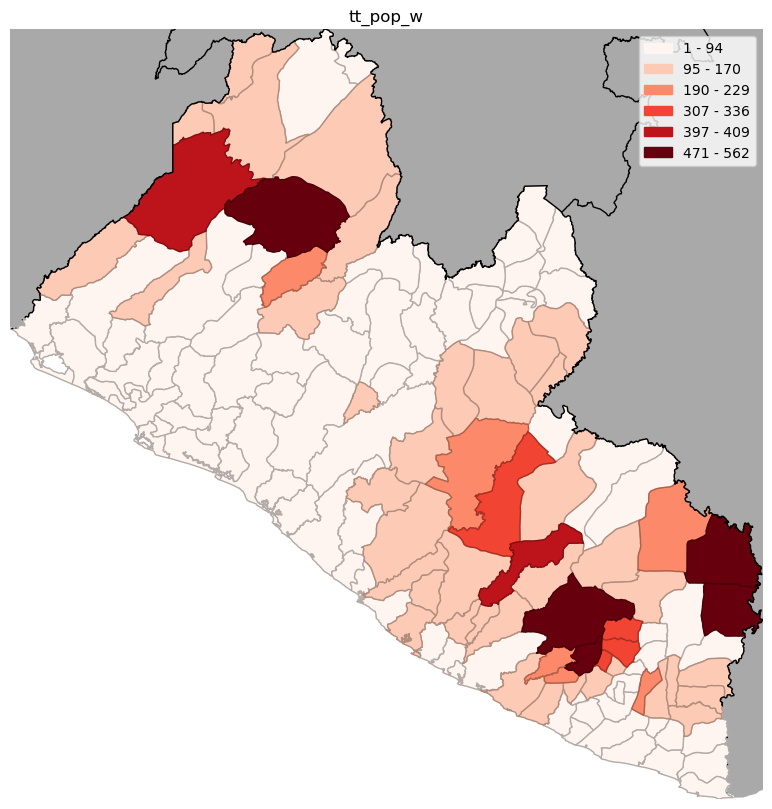

In [65]:
mapMisc.static_map_vector(adm_summary, 'tt_pop_w', add_basemap=False, add_wb_borders_lines=True, iso3=ISO3)

Adding World Bank borders and lines


<module 'matplotlib.pyplot' from 'c:\\WBG\\Anaconda3\\envs\\gostnets\\lib\\site-packages\\matplotlib\\pyplot.py'>

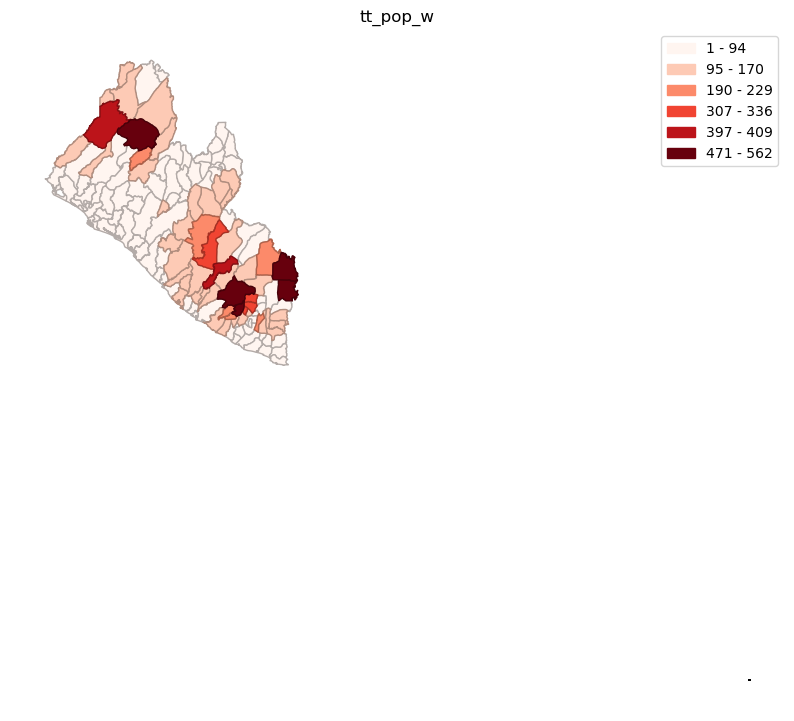

In [54]:
mapMisc.static_map_vector(gpd.read_file(adm_summary), "tt_pop_w", add_basemap=False, add_wb_borders_lines=True, iso3=ISO3)

# Write summary to readme

In [ ]:
# Write a README.md file summarizing the work so far
readme_file = "README.md"
with open(readme_file, 'w') as f:
    f.write("# GEO Road Improvements Market Access Analysis\n")
    f.write("This analysis evaluates the impact of road improvements in Georgia on travel time to ports and border crossings. \
            It compares pre- and post-intervention travel times using friction surfaces and summarizes the results at the administrative level 2 (ADM2) regions.\n \
            ")
    f.write("\n")
    f.write("Improved roads were identified from OSM data and digitized where necessary; roads were attributed with improvement status from a map provided by the project team. \
            Friction surfaces were generated using ESA CCI landcover data and road speed information. \
            Travel times to the nearest ports and border crossings were calculated using the MCP algorithm, weighted by population from WorldPop data.\n")

    f.write("![Road status and destinations map](maps/GEO_road_status_destinations.png)\n")

    f.write("## Calculating Travel Time and Improvements\n")
    f.write("Travel times to ports and border crossings were calculated using both pre- and post-intervention friction surfaces. \
            __All roads of any status were included in the calculations__ and all speeds were increased by 20% to account for improved conditions. \
            The results were summarized at the ADM2 level, providing insights into how road improvements have affected accessibility in different regions.\n")
    f.write("![Travel time to ports map](maps/GEO_tt_ports.png)\n")
    f.write("![Change in travel time to ports at ADM2 level](maps/GEO_tt_ports_ADM2_change.png)\n")

    
